**Ch30-33: 关联规则挖掘、Selenium爬虫、PageRank算法**

Source: 
[数据分析实战 45 讲](https://time.geekbang.org/column/intro/100021701?tab=intro)

---

## 关联规则挖掘

寻找项（item）与项间的关联关系，可以用于筛选一个数据集里关联关系强的那些，即作为组合出现次数超过指定阈值的。

算法的思想是查找频繁项集（frequent itemset），即一个或一组项出现的频率高于某个百分比（最小支持度/minimum support threshold）的集合。

### Apriori算法

* 从itemset的项数K=1（即只含一个item）开始遍历，不满足最小支持度的就删掉；

* K=2（两两组合）再继续遍历，再删；

* 已知重复直到删完了，获得以上的全部结果的频繁项集。

### FP-Growth, Apriori的改进算法

FP-growth: frequent pattern growth.

* 不用每次都遍历数据集（所以改进了，一共只用两遍 -> reduces I/O），第一次遍历先建立项头表（按单个item的支持度大小从高到低/降序排列）并删去不满足的items；第二次遍历把数据集里的每一条数据根据项头表的顺序排序。然后建立FP树（前缀树，每个节点就是单个item对象，一串通路可看作几个items的组合），方便挖掘频繁项集。

* 在挖掘到频繁项集之前需要找到“条件模式基/conditional pattern base”，就是把你的目标item对应的节点作为叶子节点自*底*向上（朝着根节点方向）求出这条子树 conditional FP-tree（叶子节点为此item的全部通路之和的树）。

    * 但注意“条件模式基”里面不包含你要找的那个item，故不含其所在的叶子节点。

* 直接顺着这个conditional FP子树，里面任意含叶子节点（目标item，你想找其他跟它有关联关系的项）的全部通路就是全部频繁项集。

* Cons: **building the FP-tree** can be more complex and cumbersome compared to Apriori.

---

# 实战（主要是爬虫！！！）

* 可以用pypi.org来检索Python中的包。我们找到了efficient-apriori可以用来做关联规则挖掘。`pip install()`。

    * Why '*efficient*'-apriori: 不考虑数据集中每条数据（即每个几种item的组合）出现的先后顺序。我们这次实战想要看某个导演使用的演员出现有没有关联关系，本来就不应该考虑项出现的先后顺序，所以这个包正合适！！
  
    * `itemsets,rules = apriori(data, min_support, min_confidence)`
    
* csv包写入csv文件。

* time包模拟真实用户浏览，等HTML数据完全返回后再进行抓取。

* selenium的webdriver模拟浏览器; lxml工具包来XPath解析

```python
# 以后用Selenium爬虫的时候这几行得有
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
# Use the correct path to my chromedriver
driver_path = "..."
driver = webdriver.Chrome(service=Service(driver_path))
```

* Selenium：既是编译器（来打开网页）又是解析器/选择器（通过XPath/CSS定位元素），内置了完整的XPath解析引擎，直接通过 `driver.find_elements(By.XPATH)`即可提取元素**列表**，摆脱了requests库其实也不需要再用lxml!!!（虽然底下例子还是用了）。而`driver.find_element`（**单数**）还可模拟用户操作，见之后章节。
    
    * lxml：解析*静态*HTML，比如requests出来的。
    
    * 这俩解析/选择完返回的都是当前url下的元素**列表**，可以遍历出来！！列表！！！！！！
    
    * xpath对于动态页面（像豆瓣那个直接page source找不到相关html语句需要 **inspect element (cmd+Shift+C)** 才能看到的），最好使用相对路径'//...'！！！不仅不繁琐而且即使有一层变了也不脆弱；怕一层节点不踏实的话还可以增加约束（写两层）：`//div[@class='detail']//a[contains(@class, 'title-text')]`。

In [ ]:
# 爬取某导演的电影数据集即使用的演员
import csv
import time
from selenium import webdriver
from efficient_apriori import apriori
from lxml import etree 
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

# Use the correct path to your chromedriver
driver_path = "..."
driver = webdriver.Chrome(service=Service(driver_path))

from selenium.webdriver.common.keys import Keys

# 现在豆瓣反爬机制还怪严的。这样子Selenium会自动化打开浏览器这种但是可以手动干预填验证码什么的还挺好的
driver.get("https://accounts.douban.com/passport/login")
time.sleep(20)  # 留出30秒手动登录赶紧写入验证码
# 登录后继续执行你的爬取代码，要不然每一页只让登录啥也爬不到

director = '张艺谋' 
file_name = f'L31爬取{director}电影数据集.csv'   # 一会儿用with open 'w'直接写入它自己新创建的文件
base_url = f'https://search.douban.com/movie/subject_search?search_text={director}&cat=1002&start='
with open(file_name,'w',newline='',encoding='utf-8-sig') as f:
    csv_write = csv.writer(f,dialect='excel')  # writer函数将修改后的数据直接保存到这个csv文件中
    flags=[]
    def download(request_url):
        driver.get(request_url)
        time.sleep(1)
        html = driver.find_element(By.XPATH,"//*").get_attribute("outerHTML")
        html = etree.HTML(html)
        movie_lists = html.xpath("/html/body/div[@id='wrapper']/div[@id='root']/div[1]//div[@class='item-root']/div[@class='detail']/div[@class='title']/a[@class='title-text']") 
        name_lists = html.xpath("/html/body/div[@id='wrapper']/div[@id='root']/div[1]//div[@class='item-root']/div[@class='detail']/div[@class='meta abstract_2']")
        num_per_page = len(movie_lists)
        if num_per_page >=15:   # 第一页有16条（含一条导演信息，不要这个）
            movie_lists = movie_lists[1:]
            name_lists = name_lists[1:]
        for (movie,name_list) in zip(movie_lists,name_lists):  # 别忘了爬取的元素列表都是可迭代对象，通过zip组合迭代器
            if name_list.text is None:
                continue  # 直接下一行，连zip组合中的movie也赶紧不要了。这是为什么要zip组合起来迭代而不是直接俩列表合并！！！
            # print(name_list.text) 
            names = name_list.text.split('/') # 一定熟悉str方法们；输出names **列表**
            if len(names) > 1 and names[0].strip() == director and movie.text not in flags: 
                # .strip()别忘了是去掉空格换行符等等这些；双等于号：比较变量值是否相等喵，怎么什么都不清楚了我真服了
                names[0] = movie.text
                flags.append(movie.text) 
                csv_write.writerow(names)
        print('此页下载成功')
        if num_per_page >= 14:
            return True
        else:
            return False # 即没有下一页了，告诉你爬取/翻页可以停了
    start_id = 0
    while start_id<200: # 最大抽取二百部
        request_url = base_url + str(start_id)
        has_next_page = download(request_url)  # 看函数最后四行，返回的是bool值
        if has_next_page:
            start_id +=15
        else:
            break


In [129]:
from efficient_apriori import apriori
with open(file_name,'r',encoding='utf-8-sig') as f:
    lists = csv.reader(f)
    full_sets = []
    for names in lists:
        sets_of_items = []
        for row in names:
            sets_of_items.append(row[1:].strip())  # 关联分析时不管电影名，还要去掉数据里的空格啥的
        full_sets.append(sets_of_items)
itemset,rules = apriori(full_sets,min_support=0.06,min_confidence=0.1)
print(itemset)
print(rules)

{1: {('雷佳音',): 4, ('张译',): 5, ('倪大红',): 3, ('余皑磊',): 3, ('周冬雨',): 3, ('巩俐',): 8, ('葛优',): 4, ('章子怡',): 3, ('李保田',): 3, ('陈道明',): 3, ('李雪健',): 4}, 2: {('余皑磊', '张译'): 3}}
[{张译} -> {余皑磊}, {余皑磊} -> {张译}]


# PageRank网络分析

通过你的邻居的影响力来评判你的影响力，当然无法通过邻居来访问你，并不代表你没有影响力，因为可以直接访问你，所以引入阻尼因子的概念。

networkx；创建了一个图（节点加边）对象后想要找到其中最有影响力的节点就可以用`nx.pagerank(graph_object,alpha=0.85)`。注意这个`alpha`就是我们上述提到的阻尼因子/damping parameter，即不通过任何一条通往它的有向边而直接访问（比如用户直接输入连接跳转）的概率。

见底下两个有画图的代码块，第二个图就是经过**PageRank进行了影响力计算**后根据影响力的大小进行**筛选**节点画出来的网络图。

## 元组详解、defaultdict用法（下面代码中会用到，但这里也是为了理解元组q_q）

```python
from collections import defaultdict
s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)
for new_key, new_val in s:     # 注意看这个列表（容器）内的迭代！！！！
                               # new_key,new_val这样子原来是相当于取出一个元组的[0]和[1]！！！
    d[new_key].append(new_val) # d[new_key]其实是索引到了此时对应的new_val值
a = d.items()
print(a)
b = sorted(d.items())
print(b)

# Output：
# dict_items([('yellow', [1, 3]), ('blue', [2, 4]), ('red', [1])])
# [('blue', [2, 4]), ('red', [1]), ('yellow', [1, 3])]
```

当字典中没有的key第一次出现时，`defaultdict(list)`自动为此key的**value**先返回一个**空列表**

* `list.append()`会将元组里的new_val再添加进新列表；再次遇到相同的key时（key已存在而不会写入），`list.append()`将其它value再添加进该列表。


In [14]:
import networkx as nx  # 一个关于图论和网络分析的工具。图，即节点加边（通路）
# 一个课上例子有向图(digraph)的创建（无向图对象：nx.Graph())
digraph = nx.DiGraph()
# 下面就是**有向**边的添加！！add_edge('A','B')就是指定*从A到B*的边*，传入元组喵
edges = [("A", "B"), ("A", "C"), ("A", "D"), ("B", "A"), ("B", "D"), ("C", "A"), ("D", "B"), ("D", "C")]
for edge in edges:
    digraph.add_edge(edge[0], edge[1])   # 元组也是这么索引哇！！！！
pagerank_list = nx.pagerank(digraph, alpha=1)
print("pagerank值是：", pagerank_list)
print(digraph.nodes(data=True),digraph.edges)

pagerank值是： {'A': 0.33333396911621094, 'B': 0.22222201029459634, 'C': 0.22222201029459634, 'D': 0.22222201029459634}
[('A', {}), ('B', {}), ('C', {}), ('D', {})] [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'A'), ('B', 'D'), ('C', 'A'), ('D', 'B'), ('D', 'C')]


In [19]:
# 利用networkx先对希拉里邮件进行发件人和收件人的网络关系可视化。
# 这个数据集特征特多，但注意我们只管发件人和收件人，即仅那两个特征。
# 但因为人名又的有别名，需要靠其他两个数据集通过统一的Id进行匹配，把别名和正名匹配完之后再按照Id回到原email数据集

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
emails = pd.read_csv("L33上课数据Emails.csv")
aliases = pd.read_csv("L33上课数据Aliases.csv")
print(emails.info())
print(aliases.info())
print(aliases.head())
dict_aliases = {}
for index,row in aliases.iterrows():
    dict_aliases[row['Alias']] = row['PersonId']  # dict的键值配对
persons = pd.read_csv("L33上课数据Persons.csv")
print(persons.info(),"\n",persons.head())
dict_persons = {}
for index,row in persons.iterrows():
    dict_persons[row['Id']] = row['Name']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7945 entries, 0 to 7944
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7945 non-null   int64  
 1   DocNumber                     7945 non-null   object 
 2   MetadataSubject               7649 non-null   object 
 3   MetadataTo                    7690 non-null   object 
 4   MetadataFrom                  7788 non-null   object 
 5   SenderPersonId                7788 non-null   float64
 6   MetadataDateSent              7813 non-null   object 
 7   MetadataDateReleased          7945 non-null   object 
 8   MetadataPdfLink               7945 non-null   object 
 9   MetadataCaseNumber            7945 non-null   object 
 10  MetadataDocumentClass         7945 non-null   object 
 11  ExtractedSubject              6260 non-null   object 
 12  ExtractedTo                   3288 non-null   object 
 13  Ext

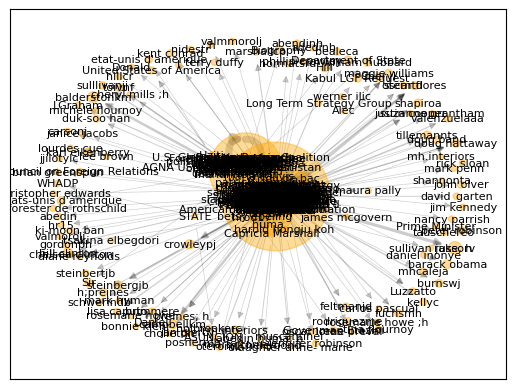

In [63]:
from collections import defaultdict
# 根据alias对人名进行转换
def unify_name(name):
    name = str(name).lower()
    name = name.replace(",","").split("@")[0]
    if name in dict_aliases.keys():
        return dict_persons[dict_aliases[name]] 
            # 如果有别名，从aliases键中取出别名的索引从persons中按索引找到正名
    return name # 没有别名的情况 

# 绘制按照PageRank影响力筛选前全部邮件网络的网络图
def show_graph(graph,layout='spring_layout',i=None):
    if layout == 'circular_layout':
        positions=nx.circular_layout(graph)
    else:
        positions=nx.spring_layout(graph)
    # 设置网络图中节点大小，因为pagerank值都很小（网络太密了）所以需要*20000
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)] 
    # when data=True, (used for attribute-lookup, that is, returns the node values (v) and node **attribute dicts (x)**) 
    # 我们在后面执行该函数前会set_attribute!! attribute就是pagerank值
    
    # 设置边宽度，为weighted边（三元组）的第三个值，即weight。对权重取平方根，避免极端权重导致边宽度差异过大。
    edgesize = [np.sqrt((e[2]['weight'])/5) for e in graph.edges(data=True)]
    # 那个e是个三元组，并且**iterates** through all the edges (edgesize为一个列表嘛）
        # and yielding the 'weight' attribute (同样是attribute-lookup)
    nx.draw_networkx_nodes(graph,positions,node_size=nodesize,alpha=0.4,node_color='orange')  # 老生常谈,alpha为透明度
    nx.draw_networkx_edges(graph,positions,width=edgesize,alpha=0.2,edge_color='k')
    nx.draw_networkx_labels(graph,positions,font_size=8)
    plt.savefig(f'L33_PageRank网络图{i}.png')
    plt.show()

# 还是像前一个代码块的第一行所述，在这个任务中我们只在乎的是收件人和发件人两个特征，即使这个数据集的特征这么多。
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)  # DataFrame直接通过.column_name索引！！
emails.MetadataTo = emails.MetadataTo.apply(unify_name)
edges_weights_temp = defaultdict(int)   # 这个int(默认值就是0）就是我们上述import defaultfict时讲到的default_factory
                                        # 因为这本身是个空dict嘛，会默认给全部往来的频次（即每个值）都先写入一个0
for from_,to_ in zip(emails.MetadataFrom,emails.MetadataTo):
    temp = (from_,to_) 
    edges_weights_temp[temp] +=1 #（每个往来（键）出现一次，它的频次（值）就加一。
edges_weight = [(key[0],key[1],val) for key,val in edges_weights_temp.items()]  # .items()取出dict中键值对
# 转化了格式！！！从{((edge_from,edge_to):频次),(...)...}转化为[(edge_from,edge_to,频次),(...),...]

# 创建有向图（注意注意！！这里面创建的图不是说“绘制”图，只是创建“图论”里面那个图（一种框架，用来算pagerank），没有可视化出来）
graph = nx.DiGraph()
graph.add_weighted_edges_from(edges_weight) # 记得嘛，添加weighted_edge时需要输入*三元组*的列表
pagerank = nx.pagerank(graph)  # 每个节点的这个pagerank影响力值由用邮件次数加权的边!!得到
nx.set_node_attributes(graph,name='pagerank',values=pagerank) # 添加成node属性，进下面那个画图函数后会作为节点大小
# 用之前写好的函数，画网络图（这才是真的可视化出来！！！！）
show_graph(graph,i=' 未筛选')


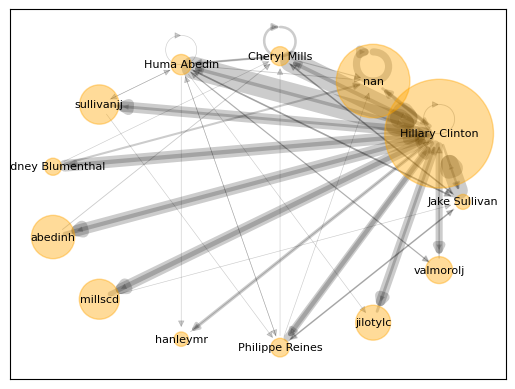

In [65]:
# 用pagerank筛选后，对上图进行精简
pagerank_threshold = 0.005
graph2 = graph.copy()
for node,attribute in graph.nodes(data=True): # again, data=True后输出我们设置的attribute dict,即pagerank
    if attribute['pagerank'] < pagerank_threshold:  # attribute是个dict，取出value需要用dict[key] = value
        graph2.remove_node(node)
show_graph(graph2,'circular_layout',i=' 筛选后')